## Q6 Isocontours of Normal Distributions

In [252]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import svm
from scipy import io, stats, cluster, ndimage
import math
import pandas as pd


# import learners

/var/folders/x3/qp9ctxln0n7bxhll0_4rvqmc0000gn/T/ipykernel_9947/2713042443.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


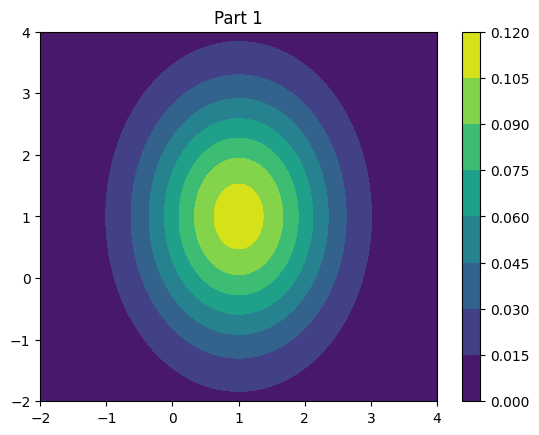

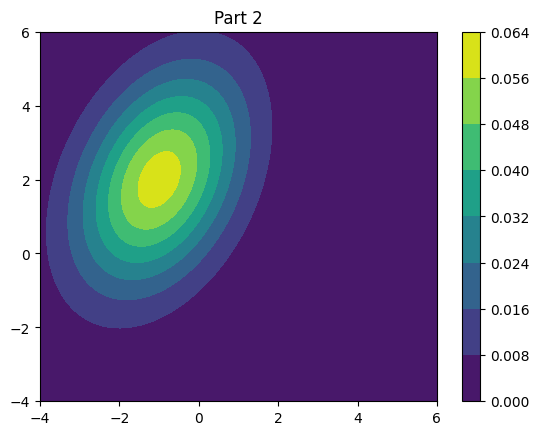

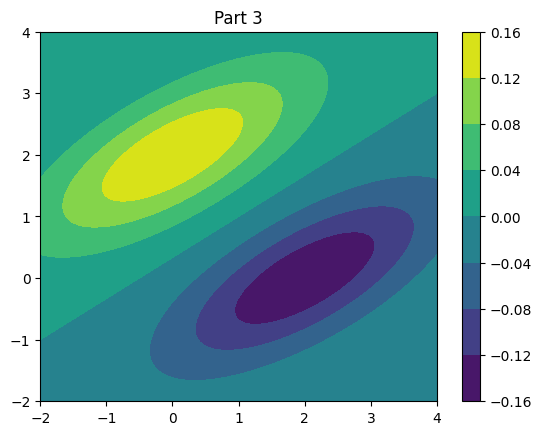

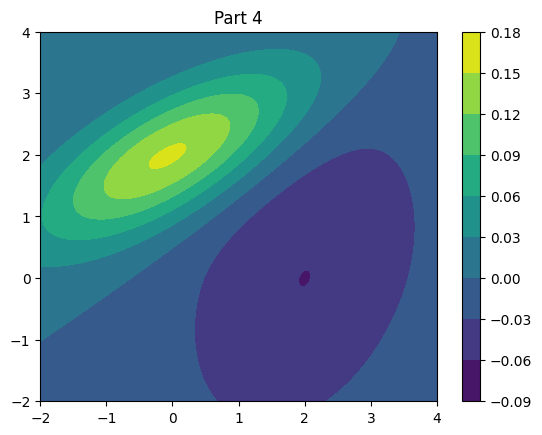

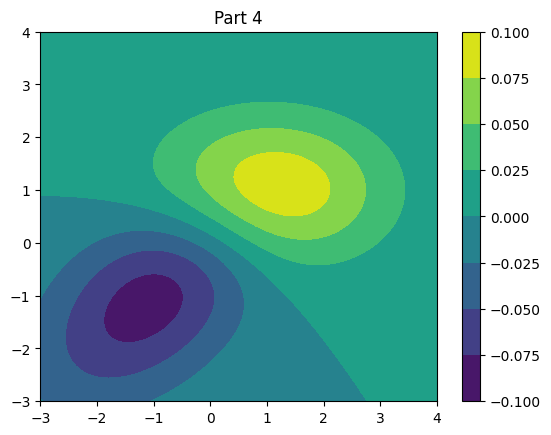

In [11]:
def create_pdf(mean, cov, start, stop):
    """create the pdf for a normal dist"""

    # create a grid of points to evaluate pdf
    x = np.linspace(start, stop, 100)
    y = np.linspace(start, stop, 100)
    X, Y = np.meshgrid(x, y) # create 2d grid 
    pos = np.dstack((X, Y))

    # create multivariate normal dist.
    rv = stats.multivariate_normal(mean, cov)

    # evaluate pdf on the grid of points
    Z = rv.pdf(pos)  # method for stats.multivariate_normal objects 
    return X, Y, Z


def plot_contours(name, X, Y, Z):
    """plot the contours of the pdf"""

    # Plot the contours
    plt.contourf(X, Y, Z) # contour w filled colors 
    plt.colorbar()
    plt.title(f"Part {name}") 
    plt.show() 


# Part 1
X, Y, Z = create_pdf([1, 1], [[1, 0], [0, 2]], -2, 4)
plot_contours(1, X, Y, Z) 

# Part 2
X, Y, Z = create_pdf([-1, 2], [[2, 1], [1, 4]], -4, 6)
plot_contours(2, X, Y, Z)

# Part 3
X, Y, Z1 = create_pdf([0, 2], [[2, 1], [1, 1]], -2, 4)
_, _, Z2 = create_pdf([2, 0], [[2, 1], [1, 1]], -2, 4)
plot_contours(3, X, Y, Z1-Z2)


# Part 4
X, Y, Z1 = create_pdf([0, 2], [[2, 1], [1, 1]], -2, 4)
_, _, Z2 = create_pdf([2, 0], [[2, 1], [1, 4]], -2, 4)
plot_contours(4, X, Y, Z1 - Z2)

# Part 4
X, Y, Z1 = create_pdf([1, 1], [[2, 0], [0, 1]], -3, 4)
_, _, Z2 = create_pdf([-1, -1], [[2, 1], [1, 2]], -3, 4)
plot_contours(4, X, Y, Z1 - Z2)

\pagebreak

### Q7 Eigenvectors of the Gaassian Covariance Matrix

Sample Mean: [3.23824999 3.75751936]
Sample Covariance: [[8.50150318 4.62655915]
 [4.62655915 6.42395033]]
Eigenvalues: [12.20446758  2.72098593]; Eigenvectors: [[ 0.78072745 -0.62487171]
 [ 0.62487171  0.78072745]]


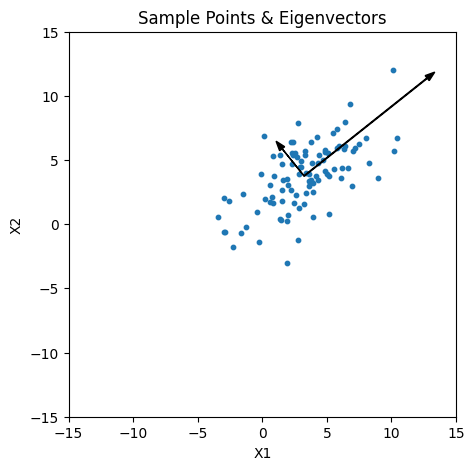

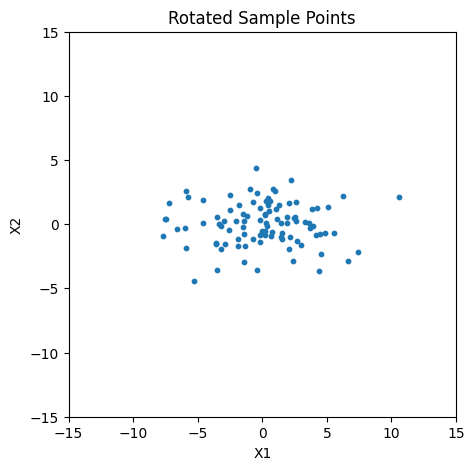

In [12]:
np.random.seed(10)

# Part 1
N39 = np.random.normal(3, 3, 100)  # mean, sd, samples
N44 = np.random.normal(2, 2, 100)

samples = np.array([(x, 0.5 * x + y) for (x, y) in zip(N39, N44)])
sample_mean = np.mean(samples, axis=0)  # mean of X, Y respectively
print(f"Sample Mean: {sample_mean}")
# print(samples)
# print(len(samples)) # 100 samples

# Part 2
sample_cov = np.cov(samples.T)  # each col is a sample point
print(f"Sample Covariance: {sample_cov}")  # Var(X), Cov(X, Y), Cov(Y, X), Var(Y)

# Part 3
# Each col is an eigenvector
# eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i]
eig_val, eig_vect = np.linalg.eig(sample_cov)
print(f"Eigenvalues: {eig_val}; Eigenvectors: {eig_vect}")

# Part 4
plt.figure(figsize=(5, 5))  # square figures
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Sample Points & Eigenvectors")
plt.scatter(samples[:, 0], samples[:, 1], s=10)  # plot x as 1st col, y as 2nd col

# arrows: covariance eigenvectors; orig at mean; mag: eigenvalues
mean_x, mean_y = sample_mean
eig_vect_1 = eig_vect[:, 0] * eig_val[0]
eig_vect_2 = eig_vect[:, 1] * eig_val[1]
plt.arrow(
    mean_x,
    mean_y,
    eig_vect_1[0],
    eig_vect_1[1],
    width=0.05,
    head_width=0.5,
    color="black",
)
plt.arrow(
    mean_x,
    mean_y,
    eig_vect_2[0],
    eig_vect_2[1],
    width=0.01,
    head_width=0.5,
    color="black",
)
plt.show()

# Part 5
# Aligns data with eigenvectors as axes -> often a step in PCA
UT = eig_vect.T  # np.linalg.eig is already unit eigen vectors
samples_minus_mean = samples - sample_mean
rotated_samples = np.dot(
    UT, samples_minus_mean.T
).T  # revert to each row is a sample point
plt.figure(figsize=(5, 5))  # square figures
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Rotated Sample Points")
plt.scatter(rotated_samples[:, 0], rotated_samples[:, 1], s=10)
plt.show()

\pagebreak

### Q8 Gaussian Classifers for Digits and Spam

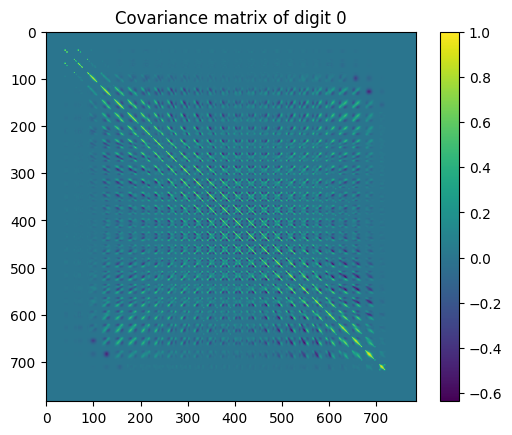

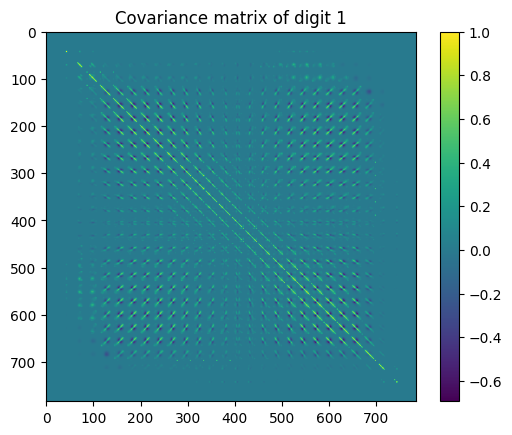

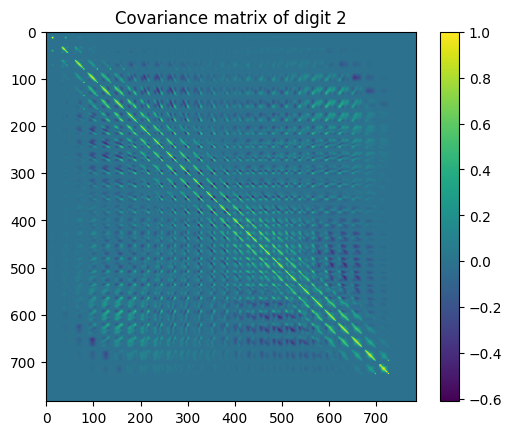

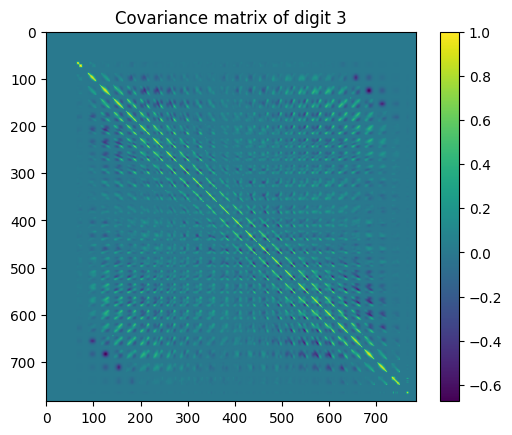

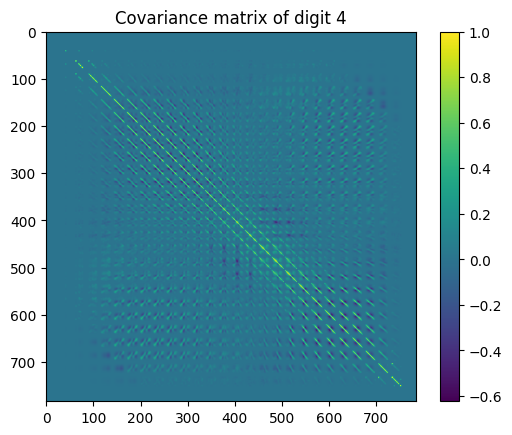

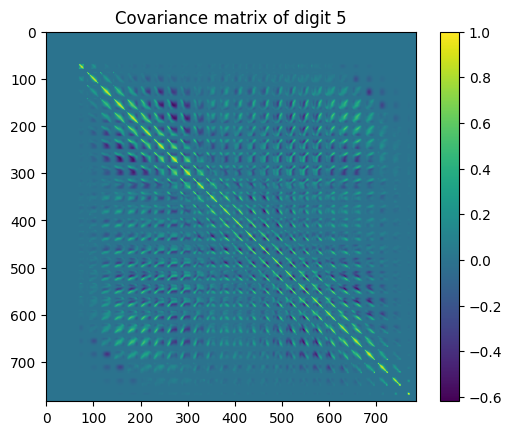

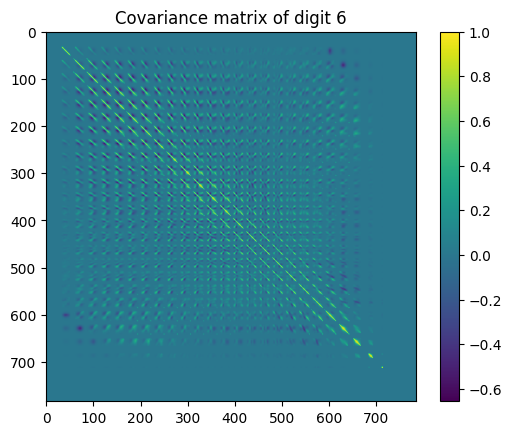

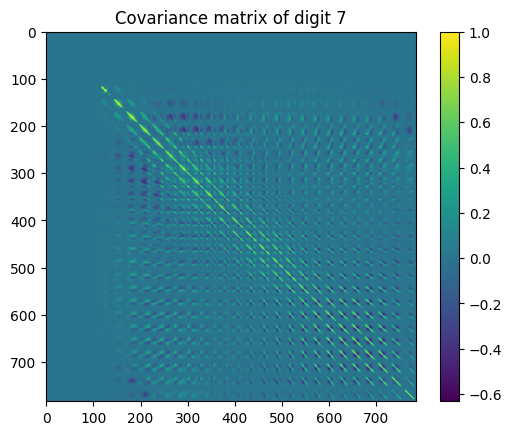

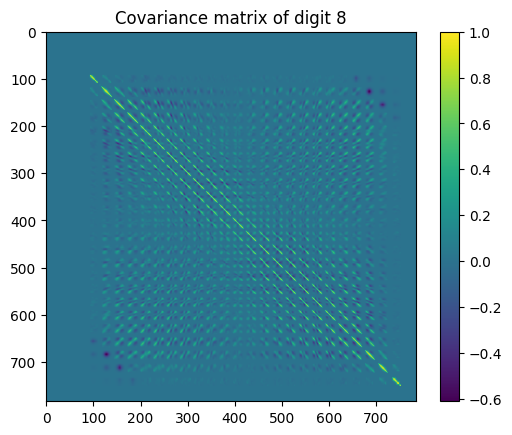

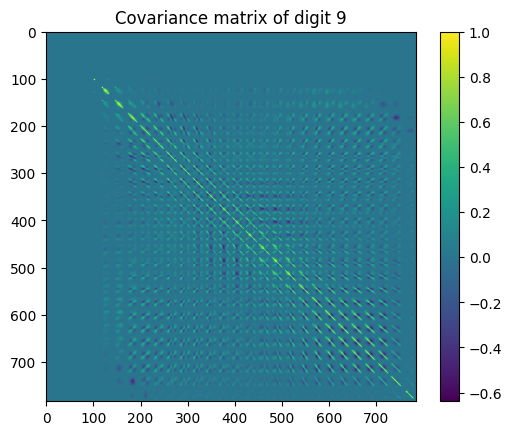

60000 60000


In [263]:
def train_val_partition(data, labels, validation_size):

    if len(data) != len(labels):
        raise ValueError("The lengths of data and labels must match.")
    total_size = len(labels)

    # in the case where a percentage is given
    if validation_size < 1:
        validation_size = int(validation_size * total_size)
    shuffled_idx = np.random.permutation(total_size)

    # uses fancy indexing, first reshuffling data, then getting the validation set
    val_data = data[shuffled_idx][:validation_size]
    val_label = labels[shuffled_idx][:validation_size]
    train_data = data[shuffled_idx][validation_size:]
    train_label = labels[shuffled_idx][validation_size:]

    return train_data, train_label, val_data, val_label

mnist = np.load("data/mnist-data-hw3.npz")

m_train_data, m_train_labels = mnist['training_data'], mnist['training_labels']
labels = np.unique(m_train_labels) # 0-9

# 8.1 & 8.2

# Normalize samples by dividing by the L2-norm
norms = np.linalg.norm(m_train_data, axis=1, keepdims=True)
norms[norms < 1e-8] = 1 # to handle small norms 
m_train_data_norm = m_train_data / norms
# reshapes m_train_data_norm by keeping the first dimension and flattening the rest -> each row is an image
m_train_data_norm = np.reshape(m_train_data_norm, (m_train_data_norm.shape[0], -1)) 

new_mnist = {}
for label in labels:
    class_idx = (m_train_labels == label).flatten()
    class_data = m_train_data_norm[class_idx]
    mean = np.mean(class_data, axis=0)  # mean: array([])
    cov = np.cov(
        class_data, rowvar=False
    )  # cov matrix: array([[], [], ...]); rowvar=false -> column represents a variable, while the rows contain observations.

    # dict with labels as keys and values as array(mean, cov matrix)
    new_mnist[label] = (
        mean,
        cov
    ) 

    # standardize cov by sd of each var, so its (-1, 1) -> normalized cov matrix
    cor = np.corrcoef(class_data, rowvar=False)
    cor[np.isnan(cor)] = 0

    plt.imshow(cor)
    plt.colorbar()
    plt.title(f"Covariance matrix of digit {label}")
    plt.show()

# print(new_mnist[0])
print(len(m_train_data_norm), len(m_train_labels))

### 8.2 
In order to visualize better, I visualized the correlation matrix, which is a standardization of the cov matrix. As seen in the graphs, the diagonal elements have a higher value, and values tend to be closer to 0 the further it is away from the diagonal. This can be interpretted as: the correlation between nearer pixels are larger than the pixels further apart. 

In [250]:
# 8.3
class GDA:

    def fit(self, train_data, train_label):
        """Train model"""
        self.classes = np.unique(train_label)  # unique classes in the dataset
        self.means = {}  # Dict to store mean of each class
        self.covmat = {}  # Dict to store covariance of each class
        self.priors = {}

        # Init pooled covariance matrix: an avg of indiv class cov_mat, weighted by class sample sizes
        self.pooled_covariance = 0

        n_total = train_data.shape[0]  # Total number of samples

        for c in self.classes:  # for each class
            data_c = train_data[
                train_label == c
            ]  # Extract samples for class c; train_label == c is a array of TF
            mean_c = np.mean(data_c, axis=0)  # Mean of class c, of each column
            covmat_c = np.cov(data_c, rowvar=False)  # cov of class c, col are variables

            # Store into dictionary
            self.means[c] = mean_c
            self.covmat[c] = covmat_c
            self.priors[c] = len(data_c) / n_total

            # Formula: Weighted sample size for pooled covariance
            self.pooled_covariance += (len(data_c) - 1) * covmat_c  

        # accounts for the degrees of freedom in each class's covariance matrix
        self.pooled_covariance /= n_total - len(self.classes) 

    def predict(self, data, mode):
        """Use the trained model to predict"""
        predictions = []
        for c in self.classes:
            if mode == "lda":
                # Use pooled covariance for LDA
                cov = self.pooled_covariance
            elif mode == "qda":
                # Use class-specific covariance for QDA
                cov = self.covmat[c]

            # Log solves overflowing and underflowing; using + instead of * prior bc log
            log_prob = stats.multivariate_normal.logpdf(
                data, mean=self.means[c], cov=cov, allow_singular=True
            ) + math.log(self.priors[c]) 
            predictions.append(log_prob)

        # finds index of maximum prob across classes for each sample
        highest_idx = np.argmax(predictions, axis=0)

        # get predicted label, and reshape into 1 column vector
        return self.classes[highest_idx].reshape((-1, 1))

    def eval_accuracy(self, data, label, mode):
        """ " Predict the labels and eval accuracy with 0-1 loss"""
        pred = self.predict(data, mode=mode).flatten()
        # print(np.sum(pred == label))
        return np.sum(pred == label) / label.shape[0]

60000 60000


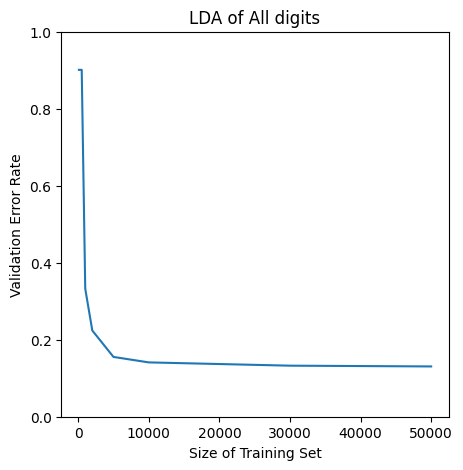

[0.901, 0.901, 0.901, 0.33240000000000003, 0.2239, 0.1553, 0.1411, 0.13260000000000005, 0.13060000000000005]


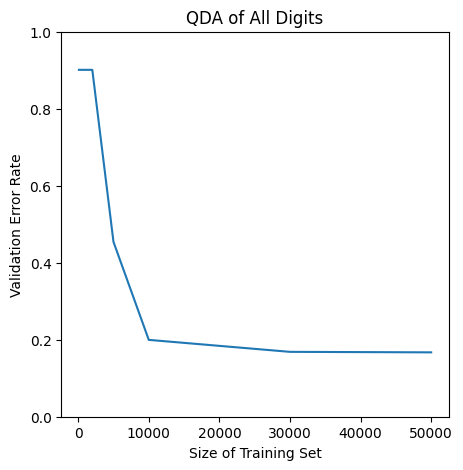

[0.901, 0.901, 0.901, 0.901, 0.901, 0.45409999999999995, 0.1996, 0.16849999999999998, 0.16720000000000002]


In [247]:
# Part 8.3 (Gaussian/linear discriminant analysis)

# Split the data, with randomly chosed validation size of 10000
print(len(m_train_data_norm), len(m_train_labels))
m_train_data, m_train_labels, m_val_data, m_val_labels = train_val_partition(
    m_train_data_norm, m_train_labels, 10000
)

# Compute the error rate (1 − # points correctly classified ) on the val set and plot it

m_val_labels.flatten()
training_size = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
lda_errors = []
qda_errors = []

for size in training_size:
    gda = GDA()
    gda.fit(m_train_data[:size], m_train_labels[:size])
    
    lda_err = 1 - gda.eval_accuracy(m_val_data, m_val_labels, mode="lda")
    lda_errors.append(lda_err)

    qda_err = 1 - gda.eval_accuracy(m_val_data, m_val_labels, mode="qda")
    qda_errors.append(qda_err)

# Part 8.3.a
plt.figure(figsize=(5, 5))
plt.plot(training_size, lda_errors)
plt.xlabel("Size of Training Set")
plt.ylabel("Validation Error Rate")
plt.title("LDA of All digits")
plt.ylim((0, 1))
plt.show()
print(lda_errors)

# Part 8.3.b
plt.figure(figsize=(5, 5))
plt.plot(training_size, qda_errors)
plt.xlabel("Size of Training Set")
plt.ylabel("Validation Error Rate")
plt.title("QDA of All Digits")
plt.ylim((0, 1))
plt.show()
print(qda_errors)

## 8.3.c
LDA seemed to perform a little better than QDA with smaller training sets, but LDA and QDA produces similar error rates on the validation set, especially for training sets that were greater than 10k. We generally may expect QDA to perform better with its increased flexibility, but QDA may result in overfitting espeically if the decision boundary is linear

## 8.3.d 

Training size 100 done.
Training size 200 done.
Training size 500 done.
Training size 1000 done.
Training size 2000 done.
Training size 5000 done.
Training size 10000 done.
Training size 30000 done.
Training size 50000 done.


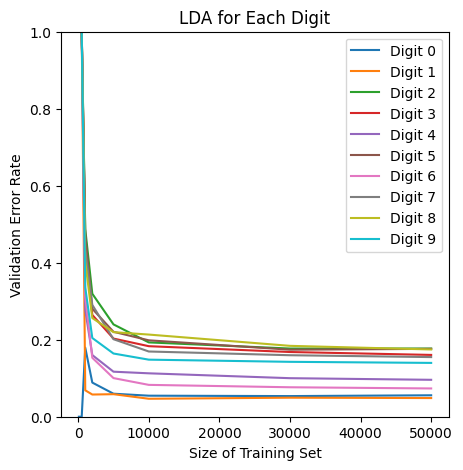

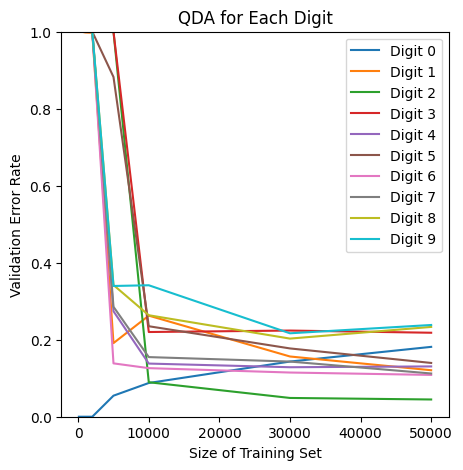

In [251]:
# Prepare to store error rates for LDA and QDA for each digit
lda_errors_per_digit = {digit: [] for digit in range(10)}
qda_errors_per_digit = {digit: [] for digit in range(10)}

# Partition the data
m_train_data, m_train_labels, m_val_data, m_val_labels = train_val_partition(
    m_train_data_norm, m_train_labels, 10000
)

# Flatten the validation labels for comparison
m_val_labels = m_val_labels.flatten()

# Define the training sizes
training_size = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

# Loop over each training size
for size in training_size:
    # Initialize the model
    gda = GDA()

    # Train model
    gda.fit(m_train_data[:size], m_train_labels[:size])
    
    # Predict for the entire validation set once using LDA
    lda_predictions = gda.predict(m_val_data, mode="lda")

    # Predict for the entire validation set once using QDA
    qda_predictions = gda.predict(m_val_data, mode="qda")

    # Calculate error rates for each digit based on these predictions
    for digit in range(10):
        # Select the indices for the current digit
        digit_indices = m_val_labels == digit
        m_val_labels_digit = m_val_labels[digit_indices]

        # Calculate errors for LDA
        lda_digit_predictions = lda_predictions[digit_indices].flatten()
        lda_errors = np.mean(lda_digit_predictions != digit)
        lda_errors_per_digit[digit].append(lda_errors)

        # Calculate errors for QDA
        qda_digit_predictions = qda_predictions[digit_indices].flatten()
        qda_errors = np.mean(qda_digit_predictions != digit)
        qda_errors_per_digit[digit].append(qda_errors)

    print(f"Training size {size} done.")


# Plotting the errors for LDA
plt.figure(figsize=(5, 5))
for digit, errors in lda_errors_per_digit.items():
    plt.plot(training_size, errors, label=f"Digit {digit}")
plt.xlabel("Size of Training Set")
plt.ylabel("Validation Error Rate")
plt.title("LDA for Each Digit")
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plotting the errors for QDA
plt.figure(figsize=(5, 5))
for digit, errors in qda_errors_per_digit.items():
    plt.plot(training_size, errors, label=f"Digit {digit}")
plt.xlabel("Size of Training Set")
plt.ylabel("Validation Error Rate")
plt.title("QDA for Each Digit")
plt.legend()
plt.ylim(0, 1)
plt.show()

# 8.3.d
For LDA, our experiments show that 0 and 1 were the easiest to classify, whereas QDA best classifies 0 and 1 but with the error rate for 0 increasing as training set gets larger. 


## 8.4 
My kaggle username is andrewcchuang, I got a accuracy score of .798 for the MNIST set. I used my LDA model without adding new features

In [255]:
def kaggle_submit(dataset, train_data, train_labels, test_data):

    gda = GDA()
    gda.fit(train_data, train_labels)

    if dataset == "mnist":
        test_data = test_data.reshape(test_data.shape[0], -1)

    test_labels = gda.predict(test_data, "lda")

    test_labels = test_labels.astype(int).flatten()
    df = pd.DataFrame({"Category": test_labels})
    df.index += 1
    df.to_csv(f"{dataset}_gda_pred.csv", index_label="Id")

kaggle_submit("mnist", m_train_data, m_train_labels, mnist["test_data"])


In [261]:
spam = np.load(f"data/spam-data-hw3.npz")

kaggle_submit(
    "spam",
    spam["training_data"],
    spam["training_labels"],
    spam["test_data"],
)

## 8.5
My kaggle username is andrewcchuang, I got a accuracy score of .783 for the Spam set. I used my LDA model without adding new features